# 1.获得基因列表

## HVG保留90%以上不是0的 + 数据挖掘关注的基因

In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import gc 

adata = sc.read_h5ad("/home/share/huadjyin/home/baiyong01/repo/hiv/pbmc_celltype_gzip.h5ad", backed='r')
print(adata.shape)
adata.var # 基因名是symbol

In [ ]:
adata.var['highly_variable_intersection'].value_counts()

In [ ]:
adata = sc.read_h5ad('/home/share/huadjyin/home/lutianyu/01HIV/02data/scrna/hvg.h5ad', backed='r')
adata.var

In [ ]:
import scipy.sparse

hvg_output_path = '/home/share/huadjyin/home/lutianyu/01HIV/02data/scrna/hvg.h5ad'
adata = sc.read(hvg_output_path)

# 提取基因表达矩阵，并补充行名和列名
gene_matrix = pd.DataFrame(
    adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X,  # 转换为密集矩阵
    index=adata.obs_names,  # 行名：细胞名称
    columns=adata.var_names  # 列名：基因名称
)

# 统计稀疏性（计算每个基因的零值比例）
zero_fraction = (gene_matrix == 0).mean(axis=0)  # 计算每列的零值比例

# 保留零值比例 <= 90% 的基因
genes_to_keep = zero_fraction[zero_fraction <= 0.9].index  # 保留符合条件的基因名称
print(f"{len(genes_to_keep)}")

# 保存筛选后的基因矩阵
# 将保留的基因名称保存到 TXT 文件
output_file = '/home/share/huadjyin/home/lutianyu/01HIV/02data/scrna/HVG_name_QC.txt'
with open(output_file, 'w') as f:
    for gene in genes_to_keep:
        f.write(gene + '\n')

print(f"保留的基因名称已保存到: {output_file}")

## 提取出591gene在基因组上的位置

In [ ]:
gff3_file = "/home/share/huadjyin/home/lutianyu/00sharedata/Ensembl/Homo_sapiens.GRCh38.113.chr.gff3"
gene_list_file = "/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/591gene.txt"
output_file = "/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2geneinfo.txt"

# 读取591基因列表
with open(gene_list_file, 'r') as f:
    gene_names = set(line.strip() for line in f)

# 读取 GFF3 文件
with open(output_file, 'w') as out_f:
    out_f.write("Chromosome\tStart\tEnd\tType\tName\n")
    with open(gff3_file, 'r') as gff_f:
        for line in gff_f:
            if line.startswith("#"):  # 跳过注释行
                continue

            # 分割行内容
            fields = line.strip().split('\t')

            # 提取属性部分
            attributes = fields[8]
            attr_dict = {}
            for attr in attributes.split(';'):
                if '=' in attr:
                    key, value = attr.split('=', 1)
                    attr_dict[key] = value

            # 检查591基因名字在不在属性部分的Name中
            if 'Name' in attr_dict and attr_dict['Name'] in gene_names:
                chromosome = fields[0]  # 染色体位置
                start = fields[3]       # 基因起始位置
                end = fields[4]         # 基因终止位置
                feature_type = fields[2]  # 第三列：特征类型
                name = attr_dict['Name']  # 基因名称
                out_f.write(f"{chromosome}\t{start}\t{end}\t{feature_type}\t{name}\n")


In [ ]:
input_file = "/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2geneinfo.txt"
name_count = {}
with open(input_file, 'r') as f:
    next(f)
    for line in f:
        name = line.strip().split('\t')[-1]
        if name in name_count:
            name_count[name] += 1
        else:
            name_count[name] = 1

# 找出重复的 Name
duplicate_names = {name: count for name, count in name_count.items() if count > 1}

PRKY重复2次，其中一个的type是假基因pseudogene，去掉假基因这一个重复的；CCL3L1没有在gff3文件中，这个基因没有match上，没纳入后续分析

## 筛选出存在基因上下游250k bp的peak段

In [ ]:
gene_info_file = "/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2geneinfo.txt"
peak_info_file = "/home/share/huadjyin/home/lutianyu/01HIV/02data/atac/peak.annotation_hg38_new_all.tsv"
output_file = "/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks.txt"

# 读取基因位置信息
genes = []
with open(gene_info_file, 'r') as f:
    next(f)
    for line in f:
        fields = line.strip().split('\t')
        chromosome = "chr" + fields[0]  # 转换为chr开头的
        start = int(fields[1])  # 基因起始位置
        end = int(fields[2])    # 基因终止位置
        name = fields[4]        # 基因名
        genes.append((chromosome, start, end, name))

# 读取 peak 注释信息并筛选符合条件的 peak
filtered_peaks = []
with open(peak_info_file, 'r') as f:
    header = f.readline().strip()
    for line in f:
        fields = line.strip().split('\t')
        peak_chr = fields[0]  # peak 所在染色体
        peak_start = int(fields[1])-1  # peak 起始位置
        peak_end = int(fields[2])    # peak 终止位置

        # 检查 peak 是否在基因的上游 250,000 bp 或下游 250,000 bp 范围内
        matched_genes = []
        for gene in genes:
            if peak_chr == gene[0]:  # 染色体匹配
                upstream_start = gene[1] - 250000  # 上游 250,000 bp    
                downstream_end = gene[2] + 250000  # 下游 250,000 bp

                # 检查 peak 是否在基因体上游到下游范围内
                if (upstream_start <= peak_start and peak_end <= downstream_end):
                    matched_genes.append(gene[3])  # 记录匹配的基因名称

        # 如果有匹配的基因，将 peak 信息添加到结果中
        if matched_genes:
            # 在第一列添加匹配的基因名称（多个基因用逗号分隔）
            matched_genes_str = ",".join(matched_genes)
            filtered_peaks.append(f"{matched_genes_str}\t{line.strip()}")

# 将筛选结果保存到输出文件
with open(output_file, 'w') as f:
    f.write("Matched_Gene\t" + header + '\n')
    for peak in filtered_peaks:
        f.write(peak + '\n')


有的行是多个基因，用逗号连接的，拆开

In [ ]:
import pandas as pd

df = pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks.txt', sep='\t')

df = df.set_index(df.columns.drop('Matched_Gene').tolist())
df = df['Matched_Gene'].str.split(',', expand=True).stack().reset_index()  # 拆分并展开
df = df.rename(columns={0: 'Matched_Gene'})  # 重命名拆分后的列
cols = df.columns.tolist()
cols = ['Matched_Gene'] + [col for col in cols if col != 'Matched_Gene']
df = df[cols]  # 重新排列顺序
df = df.sort_values(by='Matched_Gene', ascending=True)

df.to_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks_genesplit.txt', sep='\t', index=False)


In [ ]:
# 从 peak2gene_peaks_genesplit.txt 文件中提取数据
peak_gene_df = pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks_genesplit.txt', sep='\t')
peak_gene_df = peak_gene_df[['Matched_Gene', 'seqnames', 'start', 'end']].rename(
    columns={'seqnames': 'Chromosome'}
)

peak_gene_df['start'] = peak_gene_df['start'] - 1
peak_gene_df['peak_name'] = peak_gene_df['Chromosome'].astype(str) + ':' + peak_gene_df['start'].astype(str) + '-' + peak_gene_df['end'].astype(str)
peak_gene_df.to_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/all_peak2gene.csv', index=False)

In [ ]:
# 输出唯一的peak名字和gene名字
matched_genes = peak_gene_df['Matched_Gene'].unique()
peak_names = peak_gene_df['peak_name'].unique()

with open('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/all_peak2gene_unique_matched_genes.txt', 'w') as f:
    for gene in matched_genes:
        f.write(str(gene) + '\n')  

with open('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/all_peak2gene_unique_peak_names.txt', 'w') as f:
    for peak_name in peak_names:
        f.write(peak_name + '\n')  

## scRNA-seq和scATAC-seq匹配后，挑选出最后的peak--gene信息

In [ ]:
import anndata
import pandas as pd

file_path = '/home/share/huadjyin/home/caixianjun/Projects/scRNA/demo/HIV_temp/results/HIV_35_neighbors_final_matched.h5ad'
adata = anndata.read_h5ad(file_path, backed='r')



In [ ]:
# 提取peak名称
peak_names = adata.var_names[591:]

output_file = '/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/filter_peak_names.txt'
with open(output_file, 'w') as f:
    for gene in gene_names:
        f.write(f"{gene}\n")


In [ ]:
file_path = '/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks_genesplit.txt'

df = pd.read_csv(file_path, sep='\t')
df = df[['Matched_Gene', 'seqnames', 'start', 'end']]
df['position'] = df['seqnames'] + ':' + (df['start'] - 1).astype(str) + '-' + df['end'].astype(str)
print(df)

In [ ]:
with open('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/filter_peak_names.txt', 'r') as f:
    peak_names = [line.strip() for line in f]


df_filtered = df[df['position'].isin(peak_names)]
print(df_filtered)
df_filtered.to_csv("/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks_genesplit_filtered.csv", index=False)

In [10]:
import matplotlib.pyplot as plt

# 读取数据
file_path = '/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks_genesplit_filtered.csv'
df = pd.read_csv(file_path)

# 检查数据
print(df.head())

# 统计每个基因的峰数量
gene_peak_count = df.groupby('Matched_Gene').size().reset_index(name='peak_count')

# 统计峰数量的分布
peak_count_distribution = gene_peak_count['peak_count'].value_counts().sort_index().reset_index()
peak_count_distribution.columns = ['peak_count', 'gene_count']


  Matched_Gene seqnames     start       end                position
0         AAK1     chr2  69829274  69829774  chr2:69829273-69829774
1         AAK1     chr2  69436794  69437294  chr2:69436793-69437294
2         AAK1     chr2  69437309  69437809  chr2:69437308-69437809
3         AAK1     chr2  69914645  69915145  chr2:69914644-69915145
4         AAK1     chr2  69387072  69387572  chr2:69387071-69387572


In [11]:
max(gene_peak_count['peak_count'])

93

In [12]:
gene_peak_count['peak_count'].median()

6.0

    peak_count  gene_count
0            1          38
1            2          59
2            3          61
3            4          61
4            5          56
..         ...         ...
57          76           1
58          88           1
59          89           1
60          91           1
61          93           1

[62 rows x 2 columns]


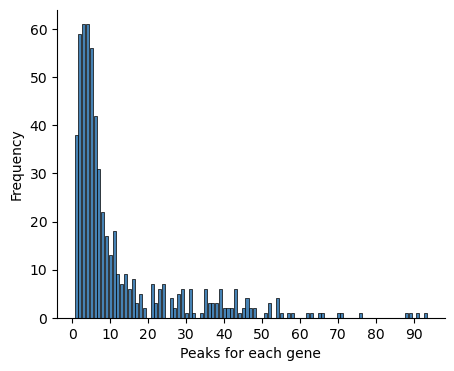

In [ ]:
import numpy as np
print(peak_count_distribution)

# 绘制柱状图
plt.figure(figsize=(5, 4))
plt.bar(
    peak_count_distribution['peak_count'],
    peak_count_distribution['gene_count'],
    color='#4682B4',
    edgecolor='black', 
    linewidth=0.5
)

max_peak_count = peak_count_distribution['peak_count'].max()
plt.xticks(np.arange(0, max_peak_count + 1, 10))

# 设置标题和标签
plt.xlabel('Peaks for each gene')
plt.ylabel('Frequency')

ax = plt.gca()  # 获取当前坐标轴
ax.spines['top'].set_visible(False)  # 隐藏上边框
ax.spines['right'].set_visible(False)  # 隐藏右边框

output_path = f'/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/Peak_Counts_per_Gene.pdf'
plt.savefig(output_path, format='pdf', bbox_inches='tight')

plt.show()